In [256]:
! module load EBModules
! module load CUDA


The following have been reloaded with a version change:
  1) CUDA/11.3.1 => CUDA/12.0.0



In [257]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.special import binom, lambertw


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device == torch.device("cuda"):
  import cupy as cp
  cp.random.seed()
else:
  np.random.seed()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

In [258]:
def add_intercept(X):
    """
    Add 1 additional feature dimension to regressor matrix
    Input:
      X: n_observations * n_features
    Output:
      X_prime: n_observations * (n_features + 1)
    """
    if device == torch.device("cuda"):
      X_prime = cp.concatenate([X, cp.ones((X.shape[0], 1))], 1) # ?xlei: why intercept column constant 1?
    else:
      X_prime = np.concatenate([X, np.ones((X.shape[0], 1))], 1) # ?xlei: why intercept column constant 1?
    return X_prime

In [259]:
def beta_generator(n_features, n_sims, is_fixed_beta):
    if device == torch.device("cuda"):
      if is_fixed_beta:
          beta = cp.random.normal(size=(n_features, 1))
          betas = cp.repeat(cp.expand_dims(beta, axis=0), repeats=n_sims, axis=0)
      else:
          betas = cp.random.normal(size=(n_sims, n_features, 1))
    else:
      if is_fixed_beta:
          beta = np.random.normal(size=(n_features, 1))
          betas = np.repeat(np.expand_dims(beta, axis=0), repeats=n_sims, axis=0)
      else:
          betas = np.random.normal(size=(n_sims, n_features, 1))

    return betas

Text(0, 0.5, 'expected value of beta.T*beta')

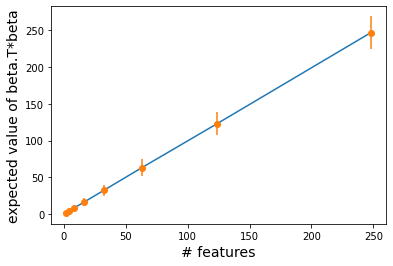

In [260]:
# sanity check: expected value of beta.T beta is n_features
n_sims = 1000
n_features_list = [2,4,8,16,32,63,124,248]
if device == torch.device("cuda"):
  results = cp.zeros((len(n_features_list), n_sims))
else: results = np.zeros((len(n_features_list), n_sims))
    
for j, n_features in enumerate(n_features_list):
  for i in range(n_sims):
    if device == torch.device("cuda"):
        beta = cp.random.normal(size=(n_features, 1))
    else:
        beta = np.random.normal(size=(n_features, 1))
    results[j,i] = beta.T@beta

if device == torch.device("cuda"):
    plt.plot(n_features_list, cp.mean(results, axis = 1).get(),)
    plt.errorbar(n_features_list, cp.mean(results, axis = 1).get(), yerr=cp.std(results, axis = 1).get(), fmt="o")
else:
    plt.plot(n_features_list, np.mean(results, axis = 1))
    plt.errorbar(n_features_list, np.mean(results, axis = 1), yerr = np.std(results, axis=1), fmt = "o")
    
    
#     plt.errorbar(x, y, yerr=error, fmt='o', capsize=4)

# plt.plot(n_features_list, n_features_list, "--",color = "red", )

plt.xlabel("# features", fontsize = 14)
plt.ylabel("expected value of beta.T*beta", fontsize = 14)

In [261]:
def gaussian_simulator_old(r2, n_observations, n_features, noise_var,n_sims, is_fixed_beta = True, betas = None):
    """
    Generate multidimensional gaussian distributed regressor X, linear regression fit beta and corresponding regressand Y with additional white noise
    input:
        n_observations
        n_features
        noise_var
        n_sims
        is_fixed_beta: True by default
    Returns:
        Xs: n_sims * n_observations * n_features
        Ys: n_sims * n_obervations * 1
        betas: n_sims * n_features * 1
        R2s: n_sims * 1
    """
    if device == torch.device("cpu"):
      X_cov = np.eye(n_features)
      X_mean = np.zeros(n_features)
    else:
      X_cov = cp.eye(n_features)
      X_mean = cp.zeros(n_features)
    desired_sig_var = r2 * noise_var / (1 - r2)
    Y_mean = 0

    Xs = []
    Ys = []
    R2s = []
    if not is_fixed_beta:
      if device == torch.device("cpu"):
        betas = np.zeros((n_sims, n_features))
        for i in range(n_sims):
            beta = np.random.normal(size=(n_features, 1))  # beta
            sig_var = beta.T @ X_cov @ beta
            beta = ((desired_sig_var / sig_var) ** 0.5) * beta
            cur_Y_mean = X_mean @ beta
            Y_mean = Y_mean - cur_Y_mean
            X = np.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                          size=(n_observations,))#features
            eps = np.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
            sig = (X @ beta).squeeze()
            Y = Y_mean + sig + eps# generate observations with noise added
            Xs.append(X)
            Ys.append(Y)
            betas[i,:] = beta.T
            R2s.append(r2)
        return np.asarray(Xs), np.asarray(Ys), betas, np.asarray(R2s)
      else:
        betas = cp.zeros((n_sims, n_features))
        for i in range(n_sims):
            beta = cp.random.normal(size=(n_features, 1))  # beta
            sig_var = beta.T @ X_cov @ beta
            beta = ((desired_sig_var / sig_var) ** 0.5) * beta
            cur_Y_mean = X_mean @ beta
            Y_mean = Y_mean - cur_Y_mean
            X = cp.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                          size=(n_observations,))#features
            eps = cp.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
            sig = (X @ beta).squeeze()

            Y = Y_mean + sig + eps# generate observations with noise added
            Xs.append(X)

            Ys.append(Y)
            betas[i,:] = beta.T
            R2s.append(r2)
        return cp.asarray(Xs), cp.asarray(Ys), betas, cp.asarray(R2s)
    else:
        if (betas == None).any():
            if device == torch.device("cpu"):
                betas = np.zeros((n_sims, n_features))
                beta = np.random.normal(size=(n_features, 1))
                for i in range(n_sims):
                    betas[i,:] = beta.T
                    sig_var = beta.T @ X_cov @ beta
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean @ beta
                    Y_mean = Y_mean - cur_Y_mean
                    X = np.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                                  size=(n_observations,))#features
                    eps = np.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X @ beta).squeeze()
                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)
                    Ys.append(Y)
                    betas[i,:] = beta.T
                    R2s.append(r2)
                return np.asarray(Xs), np.asarray(Ys), betas, np.asarray(R2s)
            else:
                betas = cp.zeros((n_sims, n_features))
                beta = cp.random.normal(size=(n_features, 1))
                for i in range(n_sims):
                    betas[i,:] = beta.T
                    sig_var = beta.T @ X_cov @ beta
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean @ beta
                    Y_mean = Y_mean - cur_Y_mean
                    X = cp.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                                  size=(n_observations,))#features
                    eps = cp.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X @ beta).squeeze()

                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)

                    Ys.append(Y)
                    betas[i,:] = beta.T
                    R2s.append(r2)
        else: 
            if device == torch.device("cpu"):
            
            
                for i in range(n_sims):
                    beta = betas[i,:]
                    
                    sig_var = beta.T @ X_cov @ beta
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean @ beta
                    Y_mean = Y_mean - cur_Y_mean
                    X = np.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                                  size=(n_observations,))#features
                    eps = np.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X @ beta).squeeze()
                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)
                    Ys.append(Y)
                    betas[i,:] = beta
                    R2s.append(r2)
                return np.asarray(Xs), np.asarray(Ys), betas, np.asarray(R2s)
            else:
            
                for i in range(n_sims):
                    beta = betas[i,:].T
                    sig_var = beta.T @ X_cov @ beta
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean @ beta
                    Y_mean = Y_mean - cur_Y_mean
                    X = cp.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                                  size=(n_observations,))#features
                    eps = cp.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X @ beta).squeeze()

                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)

                    Ys.append(Y)
                    betas[i,:] = beta.T
                    R2s.append(r2)
            
        return cp.asarray(Xs), cp.asarray(Ys), betas, cp.asarray(R2s)

In [262]:
x = np.zeros((4,4))
cords_X, cords_Y = np.meshgrid(np.arange(2), np.arange(2))
print(cords_X, cords_Y)
print(x[cords_X, cords_Y])

[[0 1]
 [0 1]] [[0 0]
 [1 1]]
[[0. 0.]
 [0. 0.]]


In [263]:
def subset_feature_gaussian_simulator_old(r2, n_observations, n_features, n_subset_features, noise_var,n_sims, is_fixed_beta = True, betas = None):
    """
    Generate multidimensional gaussian distributed regressor X, linear regression fit beta and corresponding regressand Y with additional white noise
    input:
        n_observations
        n_features
        noise_var
        n_sims
        is_fixed_beta: True by default
    Returns:
        Xs: n_sims * n_observations * n_features
        Ys: n_sims * n_obervations * 1
        betas: n_sims * n_features * 1
        R2s: n_sims * 1
    """
    if device == torch.device("cpu"):
      X_cov = np.eye(n_features)
      X_mean = np.zeros(n_features)
    else:
      X_cov = cp.eye(n_features)
      X_mean = cp.zeros(n_features)
    desired_sig_var = r2 * noise_var / (1 - r2)
    Y_mean = 0

    Xs = []
    Ys = []
    R2s = []
    if not is_fixed_beta:
      if device == torch.device("cpu"):
        betas = np.zeros((n_sims, n_subset_features))
        mg_cord_x, mg_cord_y = np.meshgrid(np.arange(n_subset_features), np.arange(n_subset_features))
        for i in range(n_sims):
            beta = np.random.normal(size=(n_subset_features, 1))  # beta
            sig_var = beta.T @ X_cov[mg_cord_x,mg_cord_y ] @ beta
            beta = ((desired_sig_var / sig_var) ** 0.5) * beta
            cur_Y_mean = X_mean[:n_subset_features] @ beta
            Y_mean = Y_mean - cur_Y_mean
            
            X = np.random.standard_normal(size=(n_observations, n_features))
#             X = np.random.multivariate_normal(mean=X_mean, cov=X_cov,
#                                           size=(n_observations,))#features
            eps = np.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
            sig = (X[:,:n_subset_features] @ beta).squeeze()
            Y = Y_mean + sig + eps# generate observations with noise added
            Xs.append(X)
            Ys.append(Y)
            betas[i,:] = beta.T
            R2s.append(r2)
        return np.asarray(Xs), np.asarray(Ys), betas, np.asarray(R2s)
      else: ### todo: to be updated
        betas = cp.zeros((n_sims, n_features))
        for i in range(n_sims):
            beta = cp.random.normal(size=(n_features, 1))  # beta
            sig_var = beta.T @ X_cov @ beta
            beta = ((desired_sig_var / sig_var) ** 0.5) * beta
            cur_Y_mean = X_mean @ beta
            Y_mean = Y_mean - cur_Y_mean
            X = cp.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                          size=(n_observations,))#features
            eps = cp.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
            sig = (X @ beta).squeeze()

            Y = Y_mean + sig + eps# generate observations with noise added
            Xs.append(X)

            Ys.append(Y)
            betas[i,:] = beta.T
            R2s.append(r2)
        return cp.asarray(Xs), cp.asarray(Ys), betas, cp.asarray(R2s)
    else:
        if (betas == None):
            if device == torch.device("cpu"):
                betas = np.zeros((n_sims, n_subset_features))
                beta = np.random.normal(size=(n_subset_features, 1))
                mg_cord_x, mg_cord_y = np.meshgrid(np.arange(n_subset_features), np.arange(n_subset_features))
                for i in range(n_sims):
                    betas[i,:] = beta.T
                    sig_var = beta.T @ X_cov[mg_cord_x, mg_cord_y] @ beta
#                     print("c1")
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean[:n_subset_features] @ beta
                    
                    Y_mean = Y_mean - cur_Y_mean
#                     print("c2")
#                     start_time = time.time()
                    X = np.random.standard_normal(size=(n_observations, n_features))
#                     X = np.random.multivariate_normal(mean=X_mean, cov=X_cov,
#                                                   size=(n_observations,))#features
#                     end_time = time.time()
#                     elapsed_time = end_time - start_time

                    # Print the elapsed time
#                     print("Elapsed time: {:.4f} seconds".format(elapsed_time))
#                     print("c3")
                    eps = np.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X[:,:n_subset_features] @ beta).squeeze()
#                     print("c4")
                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)
                    Ys.append(Y)
                    betas[i,:] = beta.T
                    R2s.append(r2)
                return np.asarray(Xs), np.asarray(Ys), betas, np.asarray(R2s)
            else:
                betas = cp.zeros((n_sims, n_features))
                beta = cp.random.normal(size=(n_features, 1))
                for i in range(n_sims):
                    betas[i,:] = beta.T
                    sig_var = beta.T @ X_cov @ beta
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean @ beta
                    Y_mean = Y_mean - cur_Y_mean
                    X = cp.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                                  size=(n_observations,))#features
                    eps = cp.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X @ beta).squeeze()

                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)

                    Ys.append(Y)
                    betas[i,:] = beta.T
                    R2s.append(r2)
        else: 
            if device == torch.device("cpu"):
            
            
                for i in range(n_sims):
                    beta = betas[i,:]
                    
                    sig_var = beta.T @ X_cov @ beta
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean @ beta
                    Y_mean = Y_mean - cur_Y_mean
                    X = np.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                                  size=(n_observations,))#features
                    eps = np.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X @ beta).squeeze()
                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)
                    Ys.append(Y)
                    betas[i,:] = beta
                    R2s.append(r2)
                return np.asarray(Xs), np.asarray(Ys), betas, np.asarray(R2s)
            else:
            
                for i in range(n_sims):
                    beta = betas[i,:].T
                    sig_var = beta.T @ X_cov @ beta
                    beta = ((desired_sig_var / sig_var) ** 0.5) * beta
                    cur_Y_mean = X_mean @ beta
                    Y_mean = Y_mean - cur_Y_mean
                    X = cp.random.multivariate_normal(mean=X_mean, cov=X_cov,
                                                  size=(n_observations,))#features
                    eps = cp.random.normal(scale=noise_var**0.5, size=(n_observations,))# generate noise
                    sig = (X @ beta).squeeze()

                    Y = Y_mean + sig + eps# generate observations with noise added
                    Xs.append(X)

                    Ys.append(Y)
                    betas[i,:] = beta.T
                    R2s.append(r2)
            
        return cp.asarray(Xs), cp.asarray(Ys), betas, cp.asarray(R2s)

In [264]:
# estimators: classical fitted beta; classical optimal beta; small data no repeats
# estimator: classical fitted beta
# single neuron
def r2_largedata_classic_fitbeta_norepeats(X, Y):
    """classic estimator of r2 for linear regression for the fit beta.
    No trial to trial noise
    No high-dim case (d>m)
    No DOF

    Parameters
    ----------
    X : numpy.ndarray
        n_observations by n_features regressor matrix
    Y : numpy.ndarray
        (m observations * 1) regressand matrix

    Returns
    -------
    est_r2 :  (k_neurons,) an estimate of the r2 between (over)fit linear
                combination from regressor matrix and the regressand.
    """

    # X_int = add_intercept(X)
    X_int = X.copy() ######## todo: to change back
    n_observations, n_features = X_int.shape

    if n_observations < n_features:
      est_r2 = 1. # does not work for high d case; return R2=1 instead
      return est_r2
    else:
      if device == torch.device("cpu"):
        beta_hat, _, _, _ = np.linalg.lstsq(X_int, Y, rcond = None)
        res = np.sum((X_int @ beta_hat - Y) ** 2 , 0)
        est_r2 = (1 - (res/n_observations)/np.var(Y, ddof=1, axis=0)).squeeze()
      else:

        beta_hat, _, _, _ = cp.linalg.lstsq(X_int, Y, rcond = None)
        res = cp.sum((X_int @ beta_hat - Y) ** 2 , 0)
        est_r2 = (1 - (res/n_observations)/cp.var(Y, ddof=1, axis=0)).squeeze().get()

      try:
        if len(est_r2.shape) == 0:
          est_r2 = float(est_r2)
      except: pass

    return est_r2

In [265]:
# estimators: classical optimal beta;
# single neuron
def r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=True):
    """classic estimator of r2 for linear regression with optimal beta by fitting linear model
    No trial to trial noise
    No high-dim case (d>m)
    YES DOF

    Parameters
    ----------
    X : numpy.ndarray
        n_observations by n_features regressor matrix
    Y : numpy.ndarray
        (m observations * 1) regressand matrix

    Returns
    -------
    est_r2 :  (k_neurons,) an estimate of the r2 between optimal linear
                combination drawn from regressor matrix and the regressand.

    """
    X_int = add_intercept(X)
    n_observations, n_features = X_int.shape

    if n_observations < n_features:
      est_r2 = 1. # does not work for high d case; return R2=1 instead
    else:
      if device == torch.device("cpu"):
        beta_hat, _, _, _ = np.linalg.lstsq(X_int, Y, rcond = None)
        hat_y = X_int @ beta_hat
        rss = np.sum((hat_y - Y) ** 2.,0)
        tv = np.var(Y, ddof=1, axis = 0).squeeze()

        if use_rss:
          est_r2 = 1-(rss/(n_observations - n_features))/tv
        else:
          uev = rss/(n_observations - n_features)
          ev = np.sum((hat_y)**2.,0)
          hat_ev = (ev - n_features*uev)/n_observations
          est_r2 = (hat_ev/tv).squeeze()
      else:
        beta_hat, _, _, _ = cp.linalg.lstsq(X_int, Y, rcond = None)
        hat_y = X_int @ beta_hat
        rss = cp.sum((hat_y - Y) ** 2.,0)
        tv = cp.var(Y, ddof=1, axis = 0).squeeze()

        if use_rss:
          est_r2 = 1-(rss/(n_observations - n_features))/tv
        else:
          uev = rss/(n_observations - n_features)
          ev = cp.sum((hat_y)**2.,0)
          hat_ev = (ev - n_features*uev)/n_observations
          est_r2 = (hat_ev/tv).squeeze()


      try:
        if len(est_r2.shape) == 0:
          est_r2 = float(est_r2)
      except: pass
    return est_r2

In [266]:
# estimator: small data no repeats Kong and Valiant 2018; Dicker. Biometrika, 2014
def hid_ev_est(X, Y):
    """estimator of explained variance for linear regression with optimal beta for the
    high-dimensional case, i.e. works when the number of observations is lower
    than the number of features (d>m) in the regressor matrix (from
    Dicker. Biometrika, 2014).
    Parameters
    ----------
    X : numpy.ndarray
        n_observations by n_features regressor matrix
    Y : numpy.ndarray
        (m observations * 1) regressand matrix
    Returns
    -------
    ev_est :  (k_neurons,) an unbiased estimate of the explained variance
    --------
    """

    n_observations, n_features = X.shape

    if device == torch.device("cpu"):
      if len(Y.shape)<2:
          Y = Y[..., np.newaxis]
      _, k = Y.shape

      XXT = X @ X.T
      G = np.triu(XXT, k=1)
      averaging_constant = binom(n_observations, 2) # calculate the binomial coefficient
      ev_est = np.einsum('iq,ij,jq->q', Y, G, Y)/averaging_constant # need to check if the dim match
    else:
      if len(Y.shape)<2:
          Y = Y[..., cp.newaxis]
      _, k = Y.shape

      XXT = X @ X.T
      G = cp.triu(XXT, k=1)
      averaging_constant = binom(n_observations, 2) # calculate the binomial coefficient
      ev_est = cp.einsum('iq,ij,jq->q', Y, G, Y)/averaging_constant # need to check if the dim match

    if len(ev_est)==1:
        ev_est = float(ev_est)
    return ev_est




def r2_smalldata_norepeats(X, Y, return_num_denom=False):
    """estimator of r2 for linear regression with optimal beta [Dicker. Biometrika, 2014]
    No trial to trial noise
    YES high-dim case (d>m)

    Parameters
    ----------
    X : numpy.ndarray
        n_observations by n_features regressor matrix
    Y : numpy.ndarray
        (m observations * 1) regressand matrix

    Returns
    -------
    est_r2 :  (k_neurons,) an estimate of the r2 between (over)fit linear
                combination from regressor matrix and the regressand.
    """

    # X_int = add_intercept(X)
    if device == torch.device("cpu"):
      X_int = np.copy(X)
      ev_est = hid_ev_est(X_int, Y)
      denom = np.var(Y, ddof=1, axis=0)
      est_r2 = (ev_est/denom).squeeze()

    else:
      X_int = cp.copy(X)
      ev_est = hid_ev_est(X_int, Y)
      denom = cp.var(Y, ddof=1, axis=0)
      est_r2 = (ev_est/denom).squeeze()
    if len(est_r2.shape)==0:
      return float(est_r2)
    else: return est_r2

In [267]:
def confidence_interval(data, confidence=0.95, sigma=None):
    if device == torch.device("cpu"):
      n = len(data)  # Sample size
      mean = np.mean(data)  # Sample mean
      if sigma:  # Population standard deviation is known
          z = stats.norm.ppf(1 - (1 - confidence) / 2)  # Z-score
          margin_of_error = z * (sigma / np.sqrt(n))
      else:  # Population standard deviation is unknown
          t = stats.t.ppf(1 - (1 - confidence) / 2, n - 1)  # T-score
          sample_std = np.std(data, ddof=1)  # Sample standard deviation
          margin_of_error = t * (sample_std / np.sqrt(n))
    else:
      n = len(data)  # Sample size

      mean = cp.mean(data)  # Sample mean

      if sigma:  # Population standard deviation is known
          z = stats.norm.ppf(1 - (1 - confidence) / 2)  # Z-score
          margin_of_error = z * (sigma / cp.sqrt(n))
      else:  # Population standard deviation is unknown
          t = stats.t.ppf(1 - (1 - confidence) / 2, n - 1)  # T-score
          sample_std = cp.std(data, ddof=1)  # Sample standard deviation
          margin_of_error = t * (sample_std / cp.sqrt(n))

    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return (lower_bound, upper_bound)

# calculate confidence intervel
def batched_confidence_interval(batched_data):
  upper_bounds = []
  lower_bounds = []
  for i in range(batched_data.shape[0]):
    data = batched_data[i]
    lower_bound, upper_bound = confidence_interval(data, confidence=0.95, sigma=None)
    try:
      upper_bounds.append(upper_bound.get())
      lower_bounds.append(lower_bound.get())
    except: 
      upper_bounds.append(upper_bound)
      lower_bounds.append(lower_bound)
  return lower_bounds, upper_bounds


### R2 versus noise variance

In [70]:
# analysis 1: with fixed beta, fixed n_observations = 1000, fixed n_features = 50, how R2 changs with noise variance
n_sims = 10000
n_observations = 1000
n_features = 50
r2 = 0.6
is_fixed_beta = False
# noise_var_list = [1,2,4,8,12,16,20 ]
noise_var_list = [0.001, 0.01,0.1, 0.2,0.4,0.8,1]

# generate fixed_beta
betas = beta_generator(n_features, n_sims, is_fixed_beta)

if device == torch.device("cpu"):
    cf_est_r2s = np.zeros((len(noise_var_list), n_sims,))
    co_est_r2s_use_rss = np.zeros((len(noise_var_list), n_sims))
    co_est_r2s_no_rss = np.zeros((len(noise_var_list), n_sims))
    cs_est_r2s = np.zeros((len(noise_var_list), n_sims))
    R2s_gts = np.zeros((len(noise_var_list), n_sims,))
else:
    cf_est_r2s = cp.zeros((len(noise_var_list), n_sims,))
    co_est_r2s_use_rss = cp.zeros((len(noise_var_list), n_sims))
    co_est_r2s_no_rss = cp.zeros((len(noise_var_list), n_sims))
    cs_est_r2s = cp.zeros((len(noise_var_list), n_sims))
    R2s_gts = cp.zeros((len(noise_var_list), n_sims,))


for i, noise_var in enumerate(noise_var_list):

    Xs, Ys, updated_betas, R2s_gt = gaussian_simulator_old(r2, n_observations, n_features, 
                                                   noise_var,n_sims, is_fixed_beta = is_fixed_beta, betas = betas)
    R2s_gts[i,:] = R2s_gt[:]

    for j in range(n_sims):
      X = Xs[j, :, :]
      Y = Ys[j, :]
      
      R2_gt = R2s_gt[j]
      cf_est_r2s[i,j] = r2_largedata_classic_fitbeta_norepeats(X, Y)
      co_est_r2s_use_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=True)
      co_est_r2s_no_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=False)
      cs_est_r2s[i,j] = r2_smalldata_norepeats(X, Y, return_num_denom=False)





In [71]:
lower_bounds_cf_est, upper_bounds_cf_est = batched_confidence_interval(cf_est_r2s)
lower_bounds_gt, upper_bounds_gt = batched_confidence_interval(R2s_gts)
lower_bounds_corss_est, upper_bounds_corss_est = batched_confidence_interval(co_est_r2s_use_rss)
lower_bounds_conorss_est, upper_bounds_conorss_est = batched_confidence_interval(co_est_r2s_no_rss)
lower_bounds_cs_est, upper_bounds_cs_est = batched_confidence_interval(cs_est_r2s)

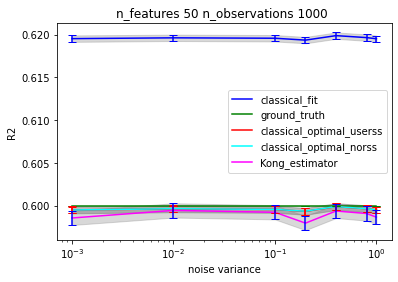

In [72]:
# plot R2 versus variance
if device == torch.device("cpu"):
    plt.plot(noise_var_list,np.mean(cf_est_r2s, axis = 1), label = "classical_fit", color = colors[0])
    plt.plot(noise_var_list,np.mean(R2s_gts, axis = 1), label = "ground_truth",color = colors[1])
    plt.plot(noise_var_list,np.mean(co_est_r2s_use_rss, axis = 1), label = "classical_optimal_userss",color = colors[2])
    plt.plot(noise_var_list,np.mean(co_est_r2s_no_rss, axis = 1), label = "classical_optimal_norss",color = colors[3])
    plt.plot(noise_var_list,np.mean(cs_est_r2s, axis = 1), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(noise_var_list, np.mean(cf_est_r2s, axis = 1), yerr=[np.mean(cf_est_r2s, axis = 1) - lower_bounds_cf_est, upper_bounds_cf_est - np.mean(cf_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(noise_var_list, np.mean(R2s_gts, axis = 1), yerr=[np.mean(R2s_gts, axis = 1) - lower_bounds_gt, upper_bounds_gt - np.mean(R2s_gts, axis = 1)],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(noise_var_list, np.mean(co_est_r2s_use_rss, axis = 1), yerr=[np.mean(co_est_r2s_use_rss, axis = 1) - lower_bounds_corss_est, upper_bounds_corss_est - np.mean(co_est_r2s_use_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(noise_var_list, np.mean(co_est_r2s_no_rss, axis = 1), yerr=[np.mean(co_est_r2s_no_rss, axis = 1) - lower_bounds_conorss_est, upper_bounds_conorss_est - np.mean(co_est_r2s_no_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(noise_var_list, np.mean(cs_est_r2s, axis = 1), yerr=[np.mean(cs_est_r2s, axis = 1) - lower_bounds_cs_est, upper_bounds_cs_est - np.mean(cs_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)

else:
    plt.plot(noise_var_list,cp.mean(cf_est_r2s, axis = 1).get(), label = "classical_fit", color = colors[0])
    plt.plot(noise_var_list,cp.mean(R2s_gts, axis = 1).get(), label = "ground_truth",color = colors[1])
    plt.plot(noise_var_list,cp.mean(co_est_r2s_use_rss, axis = 1).get(), label = "classical_optimal_userss",color = colors[2])
    plt.plot(noise_var_list,cp.mean(co_est_r2s_no_rss, axis = 1).get(), label = "classical_optimal_norss",color = colors[3])
    plt.plot(noise_var_list,cp.mean(cs_est_r2s, axis = 1).get(), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(noise_var_list, cp.mean(cf_est_r2s, axis = 1).get(), yerr=[cp.mean(cf_est_r2s, axis = 1).get() - lower_bounds_cf_est, upper_bounds_cf_est - cp.mean(cf_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(noise_var_list, cp.mean(R2s_gts, axis = 1).get(), yerr=[cp.mean(R2s_gts, axis = 1).get() - lower_bounds_gt, upper_bounds_gt - cp.mean(R2s_gts, axis = 1).get()],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(noise_var_list, cp.mean(co_est_r2s_use_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_use_rss, axis = 1).get() - lower_bounds_corss_est, upper_bounds_corss_est - cp.mean(co_est_r2s_use_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(noise_var_list, cp.mean(co_est_r2s_no_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_no_rss, axis = 1).get() - lower_bounds_conorss_est, upper_bounds_conorss_est - cp.mean(co_est_r2s_no_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(noise_var_list, cp.mean(cs_est_r2s, axis = 1).get(), yerr=[cp.mean(cs_est_r2s, axis = 1).get() - lower_bounds_cs_est, upper_bounds_cs_est - cp.mean(cs_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(noise_var_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)


plt.title("n_features %d n_observations %d " % (n_features, n_observations))
plt.legend()
plt.xlabel("noise variance")
plt.ylabel("R2")
plt.xscale("log")
# plt.hist(est_r2s)

### R2 versus n_observations

In [87]:
n_sims = 10000
n_observations_list = [10,20,40,80,100,120,160,200]
n_features = 100
r2 = 0.6
is_fixed_beta = True
noise_var = 2

data_list = n_observations_list

# generate fixed_beta
betas = beta_generator(n_features, n_sims, is_fixed_beta)

if device == torch.device("cpu"):
    cf_est_r2s = np.zeros((len(data_list), n_sims,))
    co_est_r2s_use_rss = np.zeros((len(data_list), n_sims))
    co_est_r2s_no_rss = np.zeros((len(data_list), n_sims))
    cs_est_r2s = np.zeros((len(data_list), n_sims))
    R2s_gts = np.zeros((len(data_list), n_sims,))
else:
    cf_est_r2s = cp.zeros((len(data_list), n_sims,))
    co_est_r2s_use_rss = cp.zeros((len(data_list), n_sims))
    co_est_r2s_no_rss = cp.zeros((len(data_list), n_sims))
    cs_est_r2s = cp.zeros((len(data_list), n_sims))
    R2s_gts = cp.zeros((len(data_list), n_sims,))


for i, n_observations in enumerate(data_list):

    Xs, Ys, betas, R2s_gt = gaussian_simulator_old(r2, n_observations, n_features, 
                                                   noise_var,n_sims, is_fixed_beta = is_fixed_beta,
                                                  betas = betas)
    R2s_gts[i,:] = R2s_gt[:]

    for j in range(n_sims):
      X = Xs[j, :, :]
      Y = Ys[j, :]
      beta = betas[j]
      R2_gt = R2s_gt[j]
      cf_est_r2s[i,j] = r2_largedata_classic_fitbeta_norepeats(X, Y)
      co_est_r2s_use_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=True)
      co_est_r2s_no_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=False)
      cs_est_r2s[i,j] = r2_smalldata_norepeats(X, Y, return_num_denom=False)





In [88]:
lower_bounds_cf_est, upper_bounds_cf_est = batched_confidence_interval(cf_est_r2s)
lower_bounds_gt, upper_bounds_gt = batched_confidence_interval(R2s_gts)
lower_bounds_corss_est, upper_bounds_corss_est = batched_confidence_interval(co_est_r2s_use_rss)
lower_bounds_conorss_est, upper_bounds_conorss_est = batched_confidence_interval(co_est_r2s_no_rss)
lower_bounds_cs_est, upper_bounds_cs_est = batched_confidence_interval(cs_est_r2s)

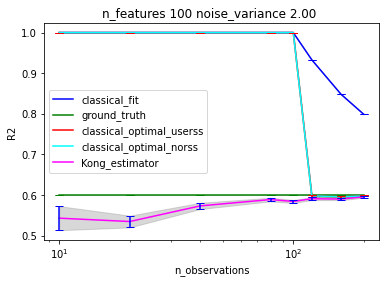

In [89]:
# plot R2 versus variance
if device == torch.device("cpu"):
    plt.plot(data_list,np.mean(cf_est_r2s, axis = 1), label = "classical_fit", color = colors[0])
    plt.plot(data_list,np.mean(R2s_gts, axis = 1), label = "ground_truth",color = colors[1])
    plt.plot(data_list,np.mean(co_est_r2s_use_rss, axis = 1), label = "classical_optimal_userss",color = colors[2])
    plt.plot(data_list,np.mean(co_est_r2s_no_rss, axis = 1), label = "classical_optimal_norss",color = colors[3])
    plt.plot(data_list,np.mean(cs_est_r2s, axis = 1), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(data_list, np.mean(cf_est_r2s, axis = 1), yerr=[np.mean(cf_est_r2s, axis = 1) - lower_bounds_cf_est, upper_bounds_cf_est - np.mean(cf_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, np.mean(R2s_gts, axis = 1), yerr=[np.mean(R2s_gts, axis = 1) - lower_bounds_gt, upper_bounds_gt - np.mean(R2s_gts, axis = 1)],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(data_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(data_list, np.mean(co_est_r2s_use_rss, axis = 1), yerr=[np.mean(co_est_r2s_use_rss, axis = 1) - lower_bounds_corss_est, upper_bounds_corss_est - np.mean(co_est_r2s_use_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(data_list, np.mean(co_est_r2s_no_rss, axis = 1), yerr=[np.mean(co_est_r2s_no_rss, axis = 1) - lower_bounds_conorss_est, upper_bounds_conorss_est - np.mean(co_est_r2s_no_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, np.mean(cs_est_r2s, axis = 1), yerr=[np.mean(cs_est_r2s, axis = 1) - lower_bounds_cs_est, upper_bounds_cs_est - np.mean(cs_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)

else:
    plt.plot(data_list,cp.mean(cf_est_r2s, axis = 1).get(), label = "classical_fit", color = colors[0])
    plt.plot(data_list,cp.mean(R2s_gts, axis = 1).get(), label = "ground_truth",color = colors[1])
    plt.plot(data_list,cp.mean(co_est_r2s_use_rss, axis = 1).get(), label = "classical_optimal_userss",color = colors[2])
    plt.plot(data_list,cp.mean(co_est_r2s_no_rss, axis = 1).get(), label = "classical_optimal_norss",color = colors[3])
    plt.plot(data_list,cp.mean(cs_est_r2s, axis = 1).get(), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(data_list, cp.mean(cf_est_r2s, axis = 1).get(), yerr=[cp.mean(cf_est_r2s, axis = 1).get() - lower_bounds_cf_est, upper_bounds_cf_est - cp.mean(cf_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, cp.mean(R2s_gts, axis = 1).get(), yerr=[cp.mean(R2s_gts, axis = 1).get() - lower_bounds_gt, upper_bounds_gt - cp.mean(R2s_gts, axis = 1).get()],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(data_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(data_list, cp.mean(co_est_r2s_use_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_use_rss, axis = 1).get() - lower_bounds_corss_est, upper_bounds_corss_est - cp.mean(co_est_r2s_use_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(data_list, cp.mean(co_est_r2s_no_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_no_rss, axis = 1).get() - lower_bounds_conorss_est, upper_bounds_conorss_est - cp.mean(co_est_r2s_no_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, cp.mean(cs_est_r2s, axis = 1).get(), yerr=[cp.mean(cs_est_r2s, axis = 1).get() - lower_bounds_cs_est, upper_bounds_cs_est - cp.mean(cs_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)


plt.title("n_features %d noise_variance %.2f " % (n_features, noise_var))
plt.legend()
plt.xlabel("n_observations")
plt.ylabel("R2")
plt.xscale("log")
# plt.hist(est_r2s)

### R2 versus subset of features

In [192]:
n_sims = 10000
n_observations = 500
n_subset_features_gen = 1000

n_features = 10000
r2 = 0.6
is_fixed_beta = True
noise_var = 2


# generate fixed_beta
betas = beta_generator(n_features, n_sims, is_fixed_beta)



Xs, Ys, betas, R2s_gt = subset_feature_gaussian_simulator_old(r2, n_observations, n_features, 
                                                                  n_subset_features_gen, noise_var,
                                                                  n_sims, is_fixed_beta = is_fixed_beta, 
                                                                  betas = None)


In [ ]:
n_subset_features_list = [100,200,400, 500, 1000,2000,3000,4000,5000]
data_list = n_subset_features_list

if device == torch.device("cpu"):
    cf_est_r2s = np.zeros((len(data_list), n_sims,))
    co_est_r2s_use_rss = np.zeros((len(data_list), n_sims))
    co_est_r2s_no_rss = np.zeros((len(data_list), n_sims))
    cs_est_r2s = np.zeros((len(data_list), n_sims))
    R2s_gts = np.zeros((len(data_list), n_sims,))
else:
    cf_est_r2s = cp.zeros((len(data_list), n_sims,))
    co_est_r2s_use_rss = cp.zeros((len(data_list), n_sims))
    co_est_r2s_no_rss = cp.zeros((len(data_list), n_sims))
    cs_est_r2s = cp.zeros((len(data_list), n_sims))
    R2s_gts = cp.zeros((len(data_list), n_sims,))

for i, n_subset_features in enumerate(data_list):
    print(i)
    
    
    R2s_gts[i,:] = R2s_gt[:]

    for j in range(n_sims):
          selected_indices = np.sort(np.random.randint(0,n_features , size=n_subset_features))
#           print(selected_indices)
          X = Xs[j, :, selected_indices].T
#           print(X.shape)
#           Y = Ys[j, selected_indices]
#           X = Xs[j, :, :n_subset_features]
          Y = Ys[j, : ]
          print(X.shape)
          print(Y.shape)
          beta = betas[j]
          R2_gt = R2s_gt[j]
          cf_est_r2s[i,j] = r2_largedata_classic_fitbeta_norepeats(X, Y)
          co_est_r2s_use_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=True)
          co_est_r2s_no_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=False)
          cs_est_r2s[i,j] = r2_smalldata_norepeats(X, Y, return_num_denom=False)





0
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 10

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)
(500,)
(500, 100)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)
(500,)
(500, 200)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)
(500,)
(500, 400)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 500)

(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)


(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)


(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)


In [ ]:
print(len(selected_indices))

In [ ]:
lower_bounds_cf_est, upper_bounds_cf_est = batched_confidence_interval(cf_est_r2s)
lower_bounds_gt, upper_bounds_gt = batched_confidence_interval(R2s_gts)
lower_bounds_corss_est, upper_bounds_corss_est = batched_confidence_interval(co_est_r2s_use_rss)
lower_bounds_conorss_est, upper_bounds_conorss_est = batched_confidence_interval(co_est_r2s_no_rss)
lower_bounds_cs_est, upper_bounds_cs_est = batched_confidence_interval(cs_est_r2s)

In [ ]:
# plot R2 versus variance
if device == torch.device("cpu"):
    plt.plot(data_list,np.mean(cf_est_r2s, axis = 1), label = "classical_fit", color = colors[0])
    plt.plot(data_list,np.mean(R2s_gts, axis = 1), label = "ground_truth",color = colors[1])
    plt.plot(data_list,np.mean(co_est_r2s_use_rss, axis = 1), label = "classical_optimal_userss",color = colors[2])
    plt.plot(data_list,np.mean(co_est_r2s_no_rss, axis = 1), label = "classical_optimal_norss",color = colors[3])
    plt.plot(data_list,np.mean(cs_est_r2s, axis = 1), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(data_list, np.mean(cf_est_r2s, axis = 1), yerr=[np.mean(cf_est_r2s, axis = 1) - lower_bounds_cf_est, upper_bounds_cf_est - np.mean(cf_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, np.mean(R2s_gts, axis = 1), yerr=[np.mean(R2s_gts, axis = 1) - lower_bounds_gt, upper_bounds_gt - np.mean(R2s_gts, axis = 1)],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(data_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(data_list, np.mean(co_est_r2s_use_rss, axis = 1), yerr=[np.mean(co_est_r2s_use_rss, axis = 1) - lower_bounds_corss_est, upper_bounds_corss_est - np.mean(co_est_r2s_use_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(data_list, np.mean(co_est_r2s_no_rss, axis = 1), yerr=[np.mean(co_est_r2s_no_rss, axis = 1) - lower_bounds_conorss_est, upper_bounds_conorss_est - np.mean(co_est_r2s_no_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, np.mean(cs_est_r2s, axis = 1), yerr=[np.mean(cs_est_r2s, axis = 1) - lower_bounds_cs_est, upper_bounds_cs_est - np.mean(cs_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)

else:
    plt.plot(data_list,cp.mean(cf_est_r2s, axis = 1).get(), label = "classical_fit", color = colors[0])
    plt.plot(data_list,cp.mean(R2s_gts, axis = 1).get(), label = "ground_truth",color = colors[1])
    plt.plot(data_list,cp.mean(co_est_r2s_use_rss, axis = 1).get(), label = "classical_optimal_userss",color = colors[2])
    plt.plot(data_list,cp.mean(co_est_r2s_no_rss, axis = 1).get(), label = "classical_optimal_norss",color = colors[3])
    plt.plot(data_list,cp.mean(cs_est_r2s, axis = 1).get(), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(data_list, cp.mean(cf_est_r2s, axis = 1).get(), yerr=[cp.mean(cf_est_r2s, axis = 1).get() - lower_bounds_cf_est, upper_bounds_cf_est - cp.mean(cf_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, cp.mean(R2s_gts, axis = 1).get(), yerr=[cp.mean(R2s_gts, axis = 1).get() - lower_bounds_gt, upper_bounds_gt - cp.mean(R2s_gts, axis = 1).get()],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(data_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(data_list, cp.mean(co_est_r2s_use_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_use_rss, axis = 1).get() - lower_bounds_corss_est, upper_bounds_corss_est - cp.mean(co_est_r2s_use_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(data_list, cp.mean(co_est_r2s_no_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_no_rss, axis = 1).get() - lower_bounds_conorss_est, upper_bounds_conorss_est - cp.mean(co_est_r2s_no_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, cp.mean(cs_est_r2s, axis = 1).get(), yerr=[cp.mean(cs_est_r2s, axis = 1).get() - lower_bounds_cs_est, upper_bounds_cs_est - cp.mean(cs_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)


plt.title("total_features %d subset_features %d n_observations %d noise_variance %.2f " % (n_features, n_subset_features_gen, n_observations, noise_var))
plt.legend()
plt.xlabel("size of subset of features")
plt.ylabel("R2")
# plt.xscale("log")
# plt.hist(est_r2s)

In [ ]:
np.mean(co_est_r2s_use_rss, axis = 1)

In [ ]:
import time
start_time = time.time()
X = np.random.standard_normal(size=(1000, 10000))
#                     X = np.random.multivariate_normal(mean=X_mean, cov=X_cov,
#                                                   size=(n_observations,))#features
end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print("Elapsed time: {:.4f} seconds".format(elapsed_time))

### R2 versus subset of features - 1 simulation and bootstrap across features and observations

In [268]:
n_sims = 1
n_bootstraps = 1000

n_observations = 500


n_subset_features_gen = 1000
n_features = 10000

r2 = 0.6
is_fixed_beta = True
noise_var = 2


# generate fixed_beta
betas = beta_generator(n_features, n_sims, is_fixed_beta = is_fixed_beta)

Xs, Ys, betas, R2s_gt = subset_feature_gaussian_simulator_old(r2, n_observations, n_features, 
                                                                  n_subset_features_gen, noise_var,
                                                                  n_sims, is_fixed_beta = is_fixed_beta, 
                                                                  betas = None)


In [251]:
def gt_R2(beta, noise_var):
    return 1-(noise_var/(noise_var + beta.T@beta))

In [320]:
n_subset_features_list = [1000,2000,4000,10000]
n_subset_observations = 500
# n_subset_features_list = [100,200,300]
data_list = n_subset_features_list

if device == torch.device("cpu"):
    cf_est_r2s = np.zeros((len(data_list), n_bootstraps,))
    co_est_r2s_use_rss = np.zeros((len(data_list), n_bootstraps))
    co_est_r2s_no_rss = np.zeros((len(data_list), n_bootstraps))
    cs_est_r2s = np.zeros((len(data_list), n_bootstraps))
    R2s_gts = np.zeros((len(data_list), n_bootstraps,))
    sub_R2s_gts = np.zeros((len(data_list), n_bootstraps,))
else:
    cf_est_r2s = cp.zeros((len(data_list), n_bootstraps,))
    co_est_r2s_use_rss = cp.zeros((len(data_list), n_bootstraps))
    co_est_r2s_no_rss = cp.zeros((len(data_list), n_bootstraps))
    cs_est_r2s = cp.zeros((len(data_list), n_bootstraps))
    R2s_gts = cp.zeros((len(data_list), n_bootstraps,))
    sub_R2s_gts = cp.zeros((len(data_list), n_bootstraps,))

for i, n_subset_features in enumerate(data_list):
    print(i)
    
    
    R2s_gts[i,:] = R2s_gt[:]

    for j in range(n_bootstraps):
          selected_indices = np.arange(n_subset_features)
#             np.sort(np.random.randint(0,n_features , size=n_subset_features))

#           selected_indices_observations = np.arange(n_observations)
#           np.random.shuffle(selected_indices_observations)
#           selected_indices_observations = np.sort(selected_indices_observations[:n_subset_observations])
#     np.arange(n_subset_observations)
    
#           print(selected_indices)
#           X = Xs[0, selected_indices_observations, :]
          X = Xs[0,:,selected_indices].T
#           X = X[:, selected_indices]
#           print(X.shape)
#           Y = Ys[j, selected_indices]
#           X = Xs[j, :, :n_subset_features]
#           Y = Ys[0, selected_indices_observations ]
          Y = Ys[0, :]
          print(X.shape)
          print(Y.shape)
          if n_subset_features >= n_subset_features_gen:
            beta = betas[0]
          else:
            beta = betas[0][selected_indices]
          R2_gt = R2s_gt[0]
            
          sub_R2s_gts[i,j] = gt_R2(beta, noise_var)
          cf_est_r2s[i,j] = r2_largedata_classic_fitbeta_norepeats(X, Y)
          co_est_r2s_use_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=True)
          co_est_r2s_no_rss[i,j] = r2_largedata_classic_optimalbeta_norepeats(X, Y, use_rss=False)
          cs_est_r2s[i,j] = r2_smalldata_norepeats(X, Y, return_num_denom=False)





0
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000

(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)
(500,)
(500, 1000)


(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)


(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)
(500,)
(500, 2000)


(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)


(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)
(500,)
(500, 4000)


(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)


(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)


(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)
(500, 10000)
(500,)


In [319]:
Xs.shape

(1, 500, 10000)

In [321]:
Xs[0,:,[1,2,3]][[1,2],:].shape

(2, 500)

In [315]:
Xs[0, [1,2], :].shape

(2, 10000)

In [314]:
Xs[0, [1,2], :][:,[1,2,3]].shape

(2, 3)

In [291]:
len(selected_indices_observations)

500

In [322]:
lower_bounds_cf_est, upper_bounds_cf_est = batched_confidence_interval(cf_est_r2s)
lower_bounds_gt, upper_bounds_gt = batched_confidence_interval(R2s_gts)
lower_bounds_sub_gt, upper_bounds_sub_gt = batched_confidence_interval(sub_R2s_gts)
lower_bounds_corss_est, upper_bounds_corss_est = batched_confidence_interval(co_est_r2s_use_rss)
lower_bounds_conorss_est, upper_bounds_conorss_est = batched_confidence_interval(co_est_r2s_no_rss)
lower_bounds_cs_est, upper_bounds_cs_est = batched_confidence_interval(cs_est_r2s)

Text(0, 0.5, 'R2')

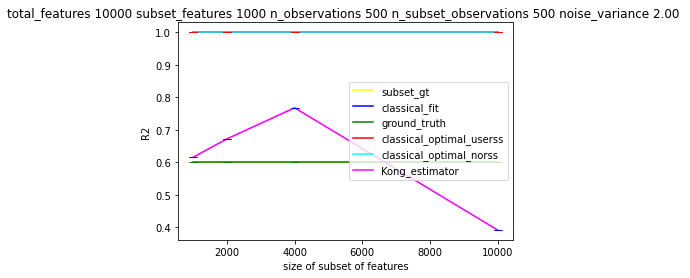

In [323]:
# plot R2 versus variance
if device == torch.device("cpu"):
    plt.plot(data_list, np.mean(sub_R2s_gts, axis = 1), label = "subset_gt", color = colors[5])
    plt.plot(data_list,np.mean(cf_est_r2s, axis = 1), label = "classical_fit", color = colors[0])
    plt.plot(data_list,np.mean(R2s_gts, axis = 1), label = "ground_truth",color = colors[1])
    plt.plot(data_list,np.mean(co_est_r2s_use_rss, axis = 1), label = "classical_optimal_userss",color = colors[2])
    plt.plot(data_list,np.mean(co_est_r2s_no_rss, axis = 1), label = "classical_optimal_norss",color = colors[3])
    plt.plot(data_list,np.mean(cs_est_r2s, axis = 1), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(data_list, np.mean(sub_R2s_gts, axis = 1), yerr=[np.mean(sub_R2s_gts, axis = 1) - lower_bounds_sub_gt, upper_bounds_sub_gt - np.mean(sub_R2s_gts, axis = 1)],
                fmt='none', ecolor=colors[5], capsize=4, )
    plt.fill_between(data_list, lower_bounds_sub_gt, upper_bounds_sub_gt, color='gray', alpha=0.3)

    
    plt.errorbar(data_list, np.mean(cf_est_r2s, axis = 1), yerr=[np.mean(cf_est_r2s, axis = 1) - lower_bounds_cf_est, upper_bounds_cf_est - np.mean(cf_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, np.mean(R2s_gts, axis = 1), yerr=[np.mean(R2s_gts, axis = 1) - lower_bounds_gt, upper_bounds_gt - np.mean(R2s_gts, axis = 1)],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(data_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(data_list, np.mean(co_est_r2s_use_rss, axis = 1), yerr=[np.mean(co_est_r2s_use_rss, axis = 1) - lower_bounds_corss_est, upper_bounds_corss_est - np.mean(co_est_r2s_use_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(data_list, np.mean(co_est_r2s_no_rss, axis = 1), yerr=[np.mean(co_est_r2s_no_rss, axis = 1) - lower_bounds_conorss_est, upper_bounds_conorss_est - np.mean(co_est_r2s_no_rss, axis = 1)],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, np.mean(cs_est_r2s, axis = 1), yerr=[np.mean(cs_est_r2s, axis = 1) - lower_bounds_cs_est, upper_bounds_cs_est - np.mean(cs_est_r2s, axis = 1)],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)

else:
    plt.plot(data_list,cp.mean(cf_est_r2s, axis = 1).get(), label = "classical_fit", color = colors[0])
    plt.plot(data_list,cp.mean(R2s_gts, axis = 1).get(), label = "ground_truth",color = colors[1])
    plt.plot(data_list,cp.mean(co_est_r2s_use_rss, axis = 1).get(), label = "classical_optimal_userss",color = colors[2])
    plt.plot(data_list,cp.mean(co_est_r2s_no_rss, axis = 1).get(), label = "classical_optimal_norss",color = colors[3])
    plt.plot(data_list,cp.mean(cs_est_r2s, axis = 1).get(), label = "Kong_estimator", color = colors[4])

    # # # Plot the confidence intervals and Add the shaded area
    plt.errorbar(data_list, cp.mean(cf_est_r2s, axis = 1).get(), yerr=[cp.mean(cf_est_r2s, axis = 1).get() - lower_bounds_cf_est, upper_bounds_cf_est - cp.mean(cf_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cf_est, upper_bounds_cf_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, cp.mean(R2s_gts, axis = 1).get(), yerr=[cp.mean(R2s_gts, axis = 1).get() - lower_bounds_gt, upper_bounds_gt - cp.mean(R2s_gts, axis = 1).get()],
                fmt='none', ecolor=colors[1], capsize=4, )
    plt.fill_between(data_list, lower_bounds_gt, upper_bounds_gt, color='gray', alpha=0.3)

    plt.errorbar(data_list, cp.mean(co_est_r2s_use_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_use_rss, axis = 1).get() - lower_bounds_corss_est, upper_bounds_corss_est - cp.mean(co_est_r2s_use_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_corss_est, upper_bounds_corss_est, color='gray', alpha=0.3)

    plt.errorbar(data_list, cp.mean(co_est_r2s_no_rss, axis = 1).get(), yerr=[cp.mean(co_est_r2s_no_rss, axis = 1).get() - lower_bounds_conorss_est, upper_bounds_conorss_est - cp.mean(co_est_r2s_no_rss, axis = 1).get()],
                fmt='none', ecolor=colors[2], capsize=4, )
    plt.fill_between(data_list, lower_bounds_conorss_est, upper_bounds_conorss_est, color='gray', alpha=0.3)


    plt.errorbar(data_list, cp.mean(cs_est_r2s, axis = 1).get(), yerr=[cp.mean(cs_est_r2s, axis = 1).get() - lower_bounds_cs_est, upper_bounds_cs_est - cp.mean(cs_est_r2s, axis = 1).get()],
                fmt='none', ecolor=colors[0], capsize=4, )
    plt.fill_between(data_list, lower_bounds_cs_est, upper_bounds_cs_est, color='gray', alpha=0.3)


plt.title("total_features %d subset_features %d n_observations %d n_subset_observations %d noise_variance %.2f " % (n_features, n_subset_features_gen, n_observations, n_subset_observations,noise_var))
plt.legend()
plt.xlabel("size of subset of features")
plt.ylabel("R2")
# plt.xscale("log")
# plt.hist(est_r2s)

In [324]:
np.mean(cf_est_r2s, axis = 1)

array([1., 1., 1., 1.])

In [296]:
lower_bounds_cf_est

[1.0, 1.0, 1.0, 1.0]

In [239]:
upper_bounds_cf_est - np.mean(cf_est_r2s, axis = 1)

array([0., 0., 0.])

In [240]:
data_list

[100, 200, 300]

In [241]:
np.mean(cf_est_r2s, axis = 1)

array([0.26806365, 0.55743367, 0.80935381])